In [3]:
import time, math, random

In [3]:
driver = g.driver

Cheaters are only biased against heads!

In [15]:
import io
import time
import base64 
import numpy as np
from PIL import Image
import pytesseract as tess

tess.pytesseract.tesseract_cmd = "C:\\Users\\alber\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe"

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains


class CoinGame():

    def __init__(self, driver=None, animation_wait_time=1):
        self.window_size = (300,850)
        self.animation_wait_time = animation_wait_time
        self.show_flipping = True

        if driver is None:
            driver = self._get_driver()
            driver.set_window_size(*self.window_size)
            driver.get('https://primerlearning.org/')
            time.sleep(30)
        self.driver = driver

        self.score = None
        self.flips = None
        self.flips_left = None

        self.element = self.driver.find_element_by_id("coin-flip-app")
        self.show_flipping_animations()
        self.reset_window()
        self.reset_data()

    def _wait_for_animations(self):
        time.sleep(self.animation_wait_time)

    def _get_driver(self):
        chrome_options = webdriver.ChromeOptions()
        mobile_emulation = { "deviceName": "iPhone 6" }
        chrome_options.add_experimental_option("mobileEmulation", mobile_emulation)
        return webdriver.Chrome(options= chrome_options)

    def reset_window(self):
        self.driver.set_window_size(*self.window_size)
        self.driver.execute_script("arguments[0].scrollIntoView();", self.element)

    def get_page_screenshot(self):
        screenshot = self.driver.get_screenshot_as_base64()
        screenshot = base64.b64decode(screenshot)
        screenshot = io.BytesIO(screenshot)
        screenshot = Image.open(screenshot).convert('L')
        return screenshot

    @staticmethod
    def _get_image_text(image):
        return tess.image_to_string(image)

    def reset_data(self):
        self.score = None
        self.flips = None
        self.flips_left = None
    
    def get_score(self) -> int:
        if self.score is None:
            self.get_data()
        return self.score

    def get_flips_left(self) -> int:
        if self.flips_left is None:
            self.get_data()
        return self.flips_left
    
    def get_flips(self) -> dict:
        if self.flips is None:
            self.get_data()
        return self.flips

    def get_data(self): 
        screenshot = self.get_page_screenshot()
        
        self.flips = CoinGame.parse_flips(
                            CoinGame._get_image_text(
                                    screenshot.crop((325, 490, 550, 600))))

        self.score = CoinGame.parse_score(
                            CoinGame._get_image_text(
                                    screenshot.crop((0, 920, 300, 985))))

        self.flips_left = CoinGame.parse_flips_left(
                                CoinGame._get_image_text(
                                        screenshot.crop((400, 920, 750, 985))))
    
    def get_end_score(self):
        screenshot = self.get_page_screenshot()
        cropped = screenshot.crop((0, 450, 750, 650))
        text = CoinGame._get_image_text(cropped)
        return CoinGame.parse_score(text)

    @staticmethod
    def parse_flips_left(string):
        if "Flips left" in string:
            return int(string.split(' ')[0])

    @staticmethod
    def parse_flips(string):
        if 'Heads: ' in string and 'Tails: ' in string:
            text_tuples = [line.split(': ') for line in string.split('\n')[:2]]
            text_dict = {k: int(v) for k, v in text_tuples}
            return text_dict
        return {'Heads': 0, 'Tails': 0}

    @staticmethod
    def parse_score(string):
        if 'Score: ' in string:
            return int(string.split('Score: ')[1])

    def _click_location(self, x, y):
        self.reset_data()
        action = ActionChains(self.driver)
        action.move_to_element_with_offset(self.element, x, y)
        action.click()
        action.perform()
        self._wait_for_animations()
    
    # Clicking locations:
    # Game: x, y = 20, 20
    # Leaderboard x, y = 330, 20
    # 1 Coin: x, y = 20, 500
    # 5 Coins: x, y = 330, 500
    # Show flipping animation: x, y = 50, 550
    # Fair: x, y = 20, 600
    # Cheater x, y = 330, 600
    # Reset Game: x, y = 155, 600

    def click_game_tab(self):
        self._click_location(20, 20)

    def click_leaderboard_tab(self):
        self._click_location(330, 20)

    def flip_one_coin(self):
        self._click_location(20, 500)
    
    def flip_five_coins(self):
        self._click_location(330, 500)
    
    def show_flipping_animations(self):
        self.show_flipping = not self.show_flipping
        self._click_location(50, 550)
    
    def label_fair(self):
        self._click_location(20, 600)

    def label_cheater(self):
        self._click_location(330, 600)

    def reset_game(self):
        self._click_location(155, 600)
        self.reset_window()
    
    def restart_browser(self):
        self.driver.quit()
        self.__init__()

g = CoinGame(driver=driver)

In [16]:
#g.flip_one_coin()
print(g.get_flips_left())
print(g.get_flips())
print(g.get_score())

Found text: 94 Flips left

94
{'Heads': 0, 'Tails': 1}
1


In [ ]:
iters = 0
confidence = 0.1
while g.get_score() is None:
    iters += 1
    if random.random() > 0.5:
        g.label_fair()
    else:
        g.label_cheater()
    time.sleep(2)
print(g.get_score())

Heads: 2
Tails: 0



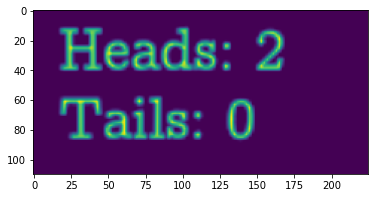

In [7]:
import matplotlib.pyplot as plt
# 490:600, 325:550
screenshot = g.get_page_screenshot()
cropped = screenshot.crop((325, 490, 550, 600))
text = CoinGame._get_image_text(cropped)
print(text)
plt.imshow(cropped)